In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

print("Welcome back, master")

1 Physical GPUs, 1 Logical GPU
Welcome back, master


<ipython-input-2-62d99aa9759e>:5: RuntimeWarning: covariance is not positive-semidefinite.
  x3 = np.random.multivariate_normal([2, 8], [[0, .75],[.75, 0]], num_observations)


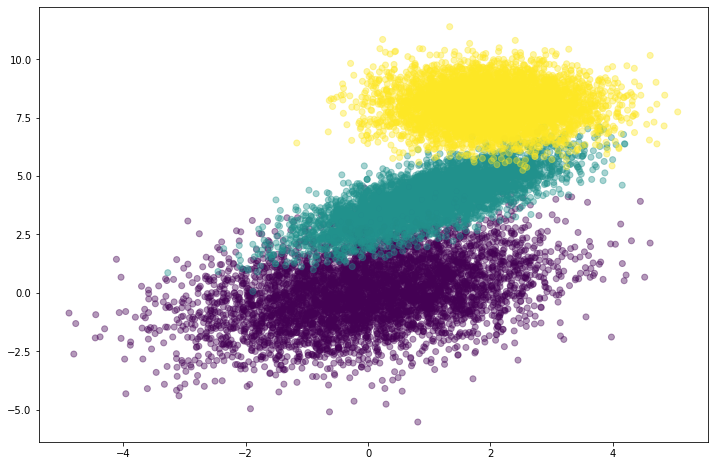

In [2]:
np.random.seed(12)
num_observations = 5000
x1 = np.random.multivariate_normal([0, 0], [[2, .75],[.75, 2]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)
x3 = np.random.multivariate_normal([2, 8], [[0, .75],[.75, 0]], num_observations)

simulated_separableish_features = np.vstack((x1, x2, x3)).astype(np.float32)
simulated_labels = np.hstack((np.zeros(num_observations), np.ones(num_observations), np.ones(num_observations) + 1)) #x1're labeled 0, x2're labeled 1, x3're labeled 2

plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)

labels_onehot = np.zeros((simulated_labels.shape[0], 3)).astype(int)
labels_onehot[np.arange(len(simulated_labels)), simulated_labels.astype(int)] = 1 #How does it work? ---> got it 
"""b = np.hstack((np.zeros(5), np.ones(5), np.ones(5)+1))
    a = np.zeros((15,3)).astype(int)
    a[np.arange(15), b.astype(int)] = 1
    print(a)
    print(b)"""
"""
u = tf.constant(simulated_labels, dtype = tf.int32)
onehot = tf.one_hot(u, depth= 3)   ----------------------------------> This is for tensorflow
"""
train_dataset, test_dataset, train_labels, test_labels = \
    train_test_split(simulated_separableish_features, labels_onehot, test_size = .1, random_state = 12) #About \ please read line structure (logical line and physical line)
                                                                                       #train_test_split is the function in sklearn
                                                                                       #test_size = 1500/15000 = 0.1 which means that len(test_dataset) = 1500


In [3]:
class hidden_function:
    def softmax(self, X):
        logits_exp = np.exp(X)
        return logits_exp/np.sum(logits_exp, axis = 1, keepdims=True)
        
    def regularization_L2_softmax_loss( self, reg_lambda, weight):
        weight_loss = 0
        for i in range(len(weight)):
            weight_loss += 0.5*reg_lambda*np.sum(weight[i]*weight[i])
        return weight_loss

    def cross_entropy_softmax_loss_array(self, softmax_probs_array, y_onehot): #softmax_probs_arrays are the values from softmax function, y_onehot is from training_labels
        indices = np.argmax(y_onehot, axis = 1).astype(int)
        predicted_probability = softmax_probs_array[np.arange(len(softmax_probs_array)), indices] #len(softmax_probs_array) = 13500
        #choosing the values depended on the position of the indices 
        """ In this function, the function still do not check the accuracy yet. It just chooses the position of the  values"""
        log_preds = np.log(predicted_probability)
        loss = -1.0 * np.sum(log_preds) / len(log_preds) #divided by len(log_preds) for getting its means
        return loss

    def relu_activation(self, data):
        return np.maximum(data, 0)

    
    def accuracy(self, x, y):
        predicted = np.argmax(x, 1) == np.argmax(y,1)
        return np.sum(predicted)*100/len(x)

In [4]:
def wb( dimC, dimR):
    w = np.random.normal(0,1, [dimC, dimR])
    b = np.zeros([1, dimR])
    return w, b

def create_wb(x): #no need to use
    weight = np.zeros([1, x], dtype = np.ndarray)
    bias = np.zeros([1, x], dtype = np.ndarray)
    return weight, bias

def create_layer(x):
    layer = np.zeros([1, x], dtype = np.ndarray)
    return layer

def activated_layer(x):
    activate = np.zeros([1,x], dtype = np.ndarray)
    return activate

def create_error(x):
    return np.zeros([1,x], dtype = np.ndarray)

def create_gradient(x):
    return np.zeros([1,x], dtype = np.ndarray), np.zeros([1,x], dtype = np.ndarray)


In [5]:
class neuron_training:
    #weight, bias = create_wb(4) #we have to do it. If not, the error will appear.
    def __init__(self, training_data, training_labels, learn_rate, num_hidden, dim):
        self.training_data = training_data
        self.training_labels = training_labels
        self.weight = [np.random.normal(0,1, shape) for shape in dim]
        self.bias = [np.zeros([1, n]) for m,n in dim]
        self.learn_rate = learn_rate
        self.num_hidden = num_hidden
        self.reglamda = 0.001
        self.dim = dim
    
    def layer(self):
        Layer[0][0] = self.training_data
        for l in range(self.num_hidden):
            Layer[0][l+1] = hidden_function().relu_activation(np.dot(Layer[0][l], self.weight[l]) + self.bias[l])
        return Layer, self.weight, self.bias

    def cost_function(self):
        softmax = hidden_function().softmax(self.layer()[0][0][len(self.layer()[0][0])-1]) #calculate the softmax at the last layer
        loss = hidden_function().cross_entropy_softmax_loss_array(softmax, self.training_labels)
        loss += hidden_function().regularization_L2_softmax_loss(self.reglamda, self.weight)
        return softmax, loss
    
    def error(self):
        error[0][self.num_hidden] = (self.cost_function()[0] - self.training_labels)/self.training_data.shape[0]
        for l in range(self.num_hidden-1, -1, -1):
            error[0][l] = np.dot(error[0][l+1], self.weight[l].T)
            error[0][l][Layer[0][l] <= 0] = 0
        return error
     
    def gradient(self):
        for l in range(self.num_hidden-1, -1,-1):
            gradient_weight[0][l] = np.dot(self.layer()[0][0][l].T, self.error()[0][l+1])
            gradient_weight[0][l] += self.reglamda*self.weight[l]
            gradient_bias[0][l] = np.sum(self.error()[0][l+1], axis = 0, keepdims = True)
            
            self.weight[l] -= self.learn_rate*gradient_weight[0][l]
            self.bias[l] -= self.learn_rate*gradient_bias[0][l]
        return self.weight, self.bias



#weight, bias = create_wb(4)
gradient_weight, gradient_bias = create_gradient(4)
Layer = create_layer(5)
error = create_error(5)

#activate = activated_layer(5)
neural = neuron_training(train_dataset, train_labels, 0.001, 4, [(2,5), (5,10), (10,5), (5,3)])
#a,b = neural.weight_bias()



In [6]:
for i in range(3001):
    if i%500 == 0 :
        print ("Loss at step {0}: {1}".format(i, neural.cost_function()[1]))
    neural.gradient()

Loss at step 0: 1.3078705188314894
Loss at step 500: 0.8781689769255515
Loss at step 1000: 0.8044693697396011
Loss at step 1500: 0.7400366945147697
Loss at step 2000: 0.629027970041215
Loss at step 2500: 0.5405647625136326
Loss at step 3000: 0.4983294963788215


In [166]:
input_layer = np.dot(test_dataset, neural.weight1)
hidden_layer = hidden_function().relu_activation(input_layer + network.bias1)
scores = np.dot(hidden_layer, network.weight2) + network.bias2
probs = hidden_function().softmax(scores)
print ("Test accuracy: {0}%".format(hidden_function().accuracy(probs, test_labels)))

[array([[-4.24538957e-03, -3.12225001e-03, -4.04293473e-04,
         -7.61680606e-05,  5.38979140e-04]]),
 array([[-2.74497903e-04, -3.93819093e-03,  0.00000000e+00,
         -7.35683722e-04,  3.15562237e-04, -3.20069818e-06,
         -7.72551902e-05, -1.70865214e-03, -1.95397822e-03,
          5.19943605e-04]]),
 array([[ 0.00000000e+00,  2.10210190e-07,  1.90545459e-03,
         -8.61580557e-04, -2.64129518e-03]]),
 array([[-0.00125487,  0.00085431,  0.00040056]])]